# Exp012: Train classifiers from corpus examples
This experiments uses regular expressions to identify possible positive and hard negative instances in multiple corpora. It may add handpicked generated examples if the corpus does not have enough examples.

In [1]:
import re
import os
import random
import numpy as np
from torch import tensor, Tensor
from torch.nn import DataParallel
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.model_selection import KFold
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import sys
sys.path.append('../source')
import models
import data
import importlib
importlib.reload(data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/scratch/dglandorf/cache...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data]

<module 'data' from '/cluster/home/dglandorf/grammarctg/experiments/../source/data.py'>

In [2]:
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(1000000) # get all sentences

# initialize corpus to check against
max_batches = 250
batch_size = 64
encoded_inputs = models.bert_tokenizer(sentences[:12*max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
encoded_inputs['sentences'] = sentences[:12*max_batches*batch_size]
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=64, shuffle=False)

100%|███████████████████████████| 4/4 [00:48<00:00, 12.13s/it]


In [3]:
# output dataset
output_path = '../data/annotated_corpus.json'
instances = pd.DataFrame(columns=['#', 'sentence', 'positive']) if not os.path.exists(output_path) else pd.read_json(output_path)
instances['positive'] = instances['positive'].astype(bool)

egp_gpt = pd.read_json("../data/egp_gpt35.json")

In [4]:
# manipulation functions for instance dataset
def get_positives(instances, nr):
    return list(instances[(instances['#'] == nr) & instances['positive']]['sentence'])
def get_negatives(instances, nr):
    return list(instances[(instances['#'] == nr) & ~instances['positive']]['sentence'])
def get_others(sentences, matches):
    return list(set(sentences).difference(set(matches)))
def add_to_instances(sentences, nr, positive=True):
    global instances
    if isinstance(sentences, list):
        for sentence in sentences:
            new_row = pd.DataFrame({'#': [nr], 'sentence': [sentence], 'positive': [positive]})
            instances = pd.concat([instances, new_row], ignore_index=True)
    else:
        new_row = pd.DataFrame({'#': [nr], 'sentence': [sentences], 'positive': [positive]})
        instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

# model training
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder).to(models.device), ratio=1, verbose=True):
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64, ratio*len(positive)/len(negative), verbose=verbose) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=verbose)
    return classifier, val_metrics

Find examples for would rules (616-638), superlatives (1105-1131), negations (1175-1205)

In [5]:
nr = 60

In [6]:
pattern = r"of the"
matches = [sentence for sentence in sentences if re.search(pattern, sentence, re.IGNORECASE)]
random.shuffle(matches)
candidates = iter(matches)

In [36]:
gpt35 = egp_gpt[egp_gpt['#']==nr].iloc[0]
egp_matches = gpt35['augmented_examples']
random.shuffle(egp_matches)
candidates = iter(egp_matches)

In [140]:
anti_pattern =  r" most "
anti_matches = [sentence for sentence in sentences if re.search(anti_pattern, sentence, re.IGNORECASE)]
random.shuffle(anti_matches)
candidates = iter(anti_matches)

In [43]:
candidates = iter(subset_sentences)

In [30]:
candidates = iter(get_positives(instances, 59))

In [53]:
while 1==1:
    if len(get_positives(instances, nr)) == 50: print("** REACHED 50 POSITIVES **")
    try:
        candidate = next(candidates)
    except StopIteration:
        print("No candidates left.")
        break
    if candidate in list(instances[instances['#'] == nr]['sentence']): continue # prevent duplicates
    #candidate = candidate.replace(",", "")
    user_response = input(f"{candidate}")
    if user_response == "c": break
    if user_response == "s": continue
    if user_response == "del": 
        instances = instances.iloc[:-1]
        continue
    new_row = pd.DataFrame({'#': [nr], 'sentence': [candidate], 'positive': [True if user_response == '2' else False]})
    instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

and it's so long, those are the two and a half most wasted hours of my life, so much so that I'm thinking about asking them to give me my money back. 2


No candidates left.


In [68]:
#instances = instances.iloc[:-11]

In [49]:
print(f'Positive: {len(get_positives(instances, nr))}, Negative: {len(get_negatives(instances, nr))}')

Positive: 157, Negative: 145


In [61]:
classifier, val_metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=3)
val_metrics

0.20334620334620335


100%|█████████████████████████| 20/20 [00:01<00:00, 11.85it/s]


Training loss: 0.038274918450042605
Val loss: 0.0069804897531867026


100%|█████████████████████████| 20/20 [00:01<00:00, 12.05it/s]


Training loss: 0.01880263558123261
Val loss: 0.010260450234636665


{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0}

Check on entire corpus

In [58]:
# shuffle inputs
shuffled_index = np.random.permutation(encoded_inputs['input_ids'].size(0))
for key, value in encoded_inputs.items():
    encoded_inputs[key] = value[shuffled_index] if isinstance(value, Tensor) else [value[i] for i in shuffled_index]
classifier = DataParallel(classifier)
batch_size = 128
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=128, shuffle=False)
scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=32000//batch_size, max_batches=125, threshold=0.5)
results = list(zip(scores, tokens, encoded_inputs['sentences'][:len(scores)]))

  8%|█▊                    | 125/1500 [00:18<03:25,  6.69it/s]


In [59]:
threshold = 0.5

subset = [(score, token, sample) for score, token, sample in results if
     score > threshold and not sample in get_positives(instances, nr)]
subset_sentences = [sample for _, _, sample in subset]
candidates = iter(subset_sentences) 
subset_sentences

["This is our busiest time of the year but I'll speak to one of our men about getting over there sometime today.",
 'I think weigh is the most fantastic of them.']

In [93]:
#add_to_instances(gpt35['augmented_examples'][100:150], nr, True)
#add_to_instances(random.sample(subset_sentences, 25), nr, False)
#add_to_instances(subset_sentences, nr, False)
#add_to_instances(random.sample(get_positives(instances, 619), 50), nr, False)
#add_to_instances(list(set(get_positives(instances, 621)).difference(get_negatives(instances, nr))), nr, False)
classifier, metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=2)
metrics

0.2


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.04it/s]


Training loss: 0.1677892841398716
Val loss: 0.1551961898803711


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.76it/s]


Training loss: 0.13315736316144466
Val loss: 0.09557819366455078


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.81it/s]


Training loss: 0.10834173485636711
Val loss: 0.08680586516857147


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.80it/s]


Training loss: 0.10036502685397863
Val loss: 0.08982415497303009


{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0}

In [64]:
models.save_classifier(classifier, nr, "corpus_training")

In [14]:
nr=619
classifier = models.load_classifier(nr, "corpus_training")

In [140]:
print(candidates)

['My teacher said that it was the best project of all. ', 'I learned to surf, this was the best part of the trip. ', 'Hi, Ally. You will miss the best party of the year!']


In [63]:
candidates = gpt35['Example'].split("\n\n") + ["I haven't the vastest clue.", "The slightest clue."]
models.probe_model(classifier, candidates)

(tensor([9.9861e-01, 9.9817e-01, 9.3891e-01, 5.9154e-04, 3.4204e-04]),
 ['of', 'of', 'of', 't', 'clue'])

In [171]:
candidates = ["I have by far the fastest car.", "He was by far the furthest singer of all time.", "It's the biggest content.", "I haven't the lushest clue."]
models.probe_model(classifier, candidates)

(tensor([0.7212, 0.9803, 0.0136, 0.0130]),
 ['fastest', '##thest', 'biggest', '##est'])

## Evaluation
Strategy: Track F1 score on validation set and precision in novel corpora sentences

In [2]:
existing_nrs = [int(name.replace(".pth","")) for name in os.listdir(f"../models/corpus_training")]
egp = data.get_egp()

In [65]:
total_folds = 5
batch_size = 32
metrics = {}

for nr in existing_nrs:
    print(f'#{nr}')
    pos = get_positives(instances, nr)
    neg = get_negatives(instances, nr)
    dataset = data.get_dataset(pos, neg, get_others(sentences, pos), models.bert_tokenizer, 64, 3*len(pos)/len(neg))
    indices = list(range(len(dataset)))
    kf = KFold(n_splits=total_folds, shuffle=True, random_state=26)
    accumulated_metrics = defaultdict(list)
    for fold_index in tqdm(range(total_folds)):
        train_indices, val_indices = list(kf.split(indices))[fold_index]
        train_dataloader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)
    
        classifier=models.RuleDetector(models.bert_encoder).to(models.device)
        _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, verbose=False)
        if val_metrics['precision'] < 0.8: # try again in those extreme cases
            _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, verbose=False)
        for metric_name, metric_value in val_metrics.items():
            accumulated_metrics[metric_name].append(metric_value)
    
    average_metrics = {metric_name: sum(metric_values) / len(metric_values) for metric_name, metric_values in accumulated_metrics.items()}
    metrics[nr] = average_metrics
    print(average_metrics)

#616


100%|█████████████████████████| 5/5 [00:29<00:00,  6.00s/it]


{'accuracy': 0.9681999999999998, 'f1': 0.9148, 'precision': 0.8842000000000001}
#617


100%|█████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


{'accuracy': 0.9536, 'f1': 0.8588000000000001, 'precision': 0.8834}
#618


100%|█████████████████████████| 5/5 [00:26<00:00,  5.39s/it]


{'accuracy': 0.9460000000000001, 'f1': 0.8762000000000001, 'precision': 0.82}
#619


100%|█████████████████████████| 5/5 [00:25<00:00,  5.07s/it]


{'accuracy': 0.8968, 'f1': 0.7083999999999999, 'precision': 0.8166}
#620


100%|█████████████████████████| 5/5 [00:28<00:00,  5.64s/it]


{'accuracy': 0.9151999999999999, 'f1': 0.5118, 'precision': 0.755}
#621


100%|█████████████████████████| 5/5 [00:16<00:00,  3.39s/it]


{'accuracy': 0.942, 'f1': 0.7417999999999999, 'precision': 0.6958}
#622


100%|█████████████████████████| 5/5 [00:48<00:00,  9.66s/it]


{'accuracy': 0.9432, 'f1': 0.5880000000000001, 'precision': 0.7612}
#623


100%|█████████████████████████| 5/5 [00:13<00:00,  2.80s/it]


{'accuracy': 0.8794000000000001, 'f1': 0.0, 'precision': 0.0}
#624


100%|█████████████████████████| 5/5 [00:14<00:00,  2.95s/it]


{'accuracy': 0.9644, 'f1': 0.8997999999999999, 'precision': 0.9358000000000001}
#625


100%|█████████████████████████| 5/5 [00:24<00:00,  4.96s/it]


{'accuracy': 0.9116, 'f1': 0.64, 'precision': 0.8082}
#626


100%|█████████████████████████| 5/5 [00:14<00:00,  2.91s/it]


{'accuracy': 0.9602, 'f1': 0.8938, 'precision': 0.8897999999999999}
#627


100%|█████████████████████████| 5/5 [00:25<00:00,  5.08s/it]


{'accuracy': 0.9132, 'f1': 0.6050000000000001, 'precision': 0.7464000000000001}
#628


100%|█████████████████████████| 5/5 [00:46<00:00,  9.23s/it]


{'accuracy': 0.9372, 'f1': 0.6122, 'precision': 0.9862}
#629


100%|█████████████████████████| 5/5 [00:38<00:00,  7.79s/it]


{'accuracy': 0.9099999999999999, 'f1': 0.3626, 'precision': 0.35140000000000005}
#630


100%|█████████████████████████| 5/5 [00:47<00:00,  9.54s/it]


{'accuracy': 0.9743999999999999, 'f1': 0.9301999999999999, 'precision': 0.8984}
#631


100%|█████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


{'accuracy': 0.9789999999999999, 'f1': 0.9468, 'precision': 0.923}
#632


100%|█████████████████████████| 5/5 [00:18<00:00,  3.72s/it]


{'accuracy': 0.9111999999999998, 'f1': 0.7002, 'precision': 0.932}
#633


100%|█████████████████████████| 5/5 [00:16<00:00,  3.33s/it]


{'accuracy': 0.913, 'f1': 0.6314, 'precision': 0.7266}
#634


100%|█████████████████████████| 5/5 [00:27<00:00,  5.54s/it]


{'accuracy': 0.9110000000000001, 'f1': 0.6854, 'precision': 0.6920000000000001}
#635


100%|█████████████████████████| 5/5 [00:14<00:00,  2.92s/it]


{'accuracy': 0.8668000000000001, 'f1': 0.3484, 'precision': 1.0}
#636


100%|█████████████████████████| 5/5 [00:30<00:00,  6.10s/it]


{'accuracy': 0.9625999999999999, 'f1': 0.9032, 'precision': 0.9149999999999998}
#637


100%|█████████████████████████| 5/5 [00:24<00:00,  4.86s/it]


{'accuracy': 0.8688, 'f1': 0.2984, 'precision': 0.9444000000000001}
#638


100%|█████████████████████████| 5/5 [00:30<00:00,  6.18s/it]

{'accuracy': 0.8988000000000002, 'f1': 0.0, 'precision': 0.0}


In [10]:
# check on examples
for nr in existing_nrs:
    classifier = models.load_classifier(nr, "corpus_training")
    rule = egp[egp['#']==nr].iloc[0]
    examples = rule['Example'].split("\n\n")
    print(rule['Can-do statement'])
    print(((models.probe_model(classifier, examples)[0]>0.5).sum()/len(examples)).item())

Can use the affirmative form with 'like'. 
1.0
Can use 'would like to invite' to make invitations.
1.0
Can use 'would like' to talk about wishes and preferences.
1.0
Can use the affirmative form.
1.0
Can use the negative forms.
1.0
Can use the question form 'would you like'.
1.0
Can use 'would' to talk about imagined situations.
0.5
Can use 'it would be' to make suggestions.
0.3333333432674408
Can use 'would' with a wide range of verbs to talk about wishes and preferences.
1.0
Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.
1.0
Can use 'would have' + '-ed'.
1.0
Can use 'would not have' + '-ed' or 'wouldn’t have' + '-ed'
1.0
Can use question forms.
0.75
Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs
1.0
Can use an increasing range of adverbs with 'would', including 'strongly', 'easily', 'especially', 'actually', 'absol

In [12]:
tc = data.TextCorpora(['brown', 'reuters'])
dc = data.CMUDoG()
threshold=0.5
test_sentences = tc.get_all_sentences() + dc.get_all_sentences()
random.shuffle(test_sentences)
max_batches = 500
batch_size = 64
test_inputs = models.bert_tokenizer(test_sentences[:max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

[nltk_data] Downloading package brown to
[nltk_data]     /cluster/scratch/dglandorf/cache...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /cluster/scratch/dglandorf/cache...
[nltk_data]   Package reuters is already up-to-date!


In [13]:
hits_path = '../data/corpus_validation_hits.json'
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(hits_path) else pd.read_json(hits_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)
#coded_instances = coded_instances[coded_instances['#']!=622]

for nr in existing_nrs:
    if nr>100: continue
    rule = egp[egp['#']==nr].iloc[0]
    if len(coded_instances[coded_instances['#']==nr]) >= 20: continue
    print(f"#{nr}: {rule['Type']}: {rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])
    classifier = models.load_classifier(nr, "corpus_training")

    scores, tokens = models.score_corpus(classifier, test_dataloader, max_positive=25, max_batches=max_batches, threshold=threshold)
    hits = [(score, token, sample) for score, token, sample in zip(scores, tokens, test_sentences[:len(scores)]) if score > threshold]
    for score, token, sample in hits[:20]:
        if sample in list(coded_instances[coded_instances['#']==nr]['sentence']): continue
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [nr],
             'sentence': [sample],
             'correct': [user_response == '2'],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
        coded_instances.to_json(hits_path)

#57: FORM: Can use the irregular superlative adjective 'best' in the phrase 'my best friend'. (ADJECTIVES: superlatives)
She's my best friend. 

Shahin is my best friend.


100%|██████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.76it/s]


His business partner is also his best friend and the fbi wants them to turn eachother 1


#58: FORM/USE: Can form a limited range of complex noun phrases with a superlative adjective  + prepositional phrase, to talk about something unique.► noun phrases ►  clauses: comparison (ADJECTIVES: superlatives)
It is the biggest zoo in the world. 

They were the happiest days of my life.


 29%|███████████████████▎                                              | 146/500 [00:12<00:30, 11.74it/s]


thanos is one of the powerful villain in marvel 1
It is the best animated musical from Disney in a whil e 2
They have the best personalities of all the heroes to be honest 2
With Gordon being one of the "few" honest cops left in Gotham, it sure drive home how alone Batman must feel with all of these questions about who is actually any good 1
I think this movie has the record for the most "fucks" in a film 2
Brazil , whose 108 billion dlr foreign debt is the largest in the developing world , has been under pressure from official and private creditors to work out an economic adjustment program with the IMF to combat rocketing inflation and foreign payments problems . 2
Among third country destinations , the Soviet Union was the largest costumer in January , taking 11 , 985 tonnes compared with nil in December and 26 , 074 tonnes in January 1986 . 2
hahaha not many people imagine their life is over after a break up and then go on to become one of the most famous people in the world 2
Situ

#70: FORM/USE: Can use 'the best' before a noun + present perfect to talk about a unique experience. (ADJECTIVES: superlatives)
It was the best birthday present I have ever had.  

That is the best game I've ever played.


100%|██████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.77it/s]


It has been a long time since I have seen the film, is there a reason to see it again ? 1
It ' s been one of the dullest corporate battles I ' ve seen ," said one analyst . 2
The place wasn't particularly busy at that time of night , and the girl who was waiting on me , who was clothed in the tightest-fitting pair of slacks I had ever seen on a woman and a sweater that showed everything there was -- and there was lots of it -- wanted to be sociable . 2
It was the fourteenth feature film produced by Pixar, and is a prequel to
2001's Monsters, Inc., marking the first time Pixar has made a prequel film. 2
The fear of disease was formerly very much the kind of fear I have tried to describe . 1
In response , the industry allowed the discovery of the motion picture as a form of fiction and thus gave the movies the essential form they have had to this day . 1
He founded the biggest social network the world has ever seen, but he seems like a person who people hate. 2
This is the only movie I h

#75: FORM: Can use '(one of) the' with an increasing range of superlative adjectives without a following noun, when the noun is understood. (ADJECTIVES: superlatives)
There have been so many embarrassing moments in my life. It's very difficult to pick the most embarrassing. 

I'm not quite sure if I agree that the car is the greatest danger to human life today, but it sure is one of the greatest. 

That period of my life was one of the worst .


 63%|█████████████████████████████████████████▊                        | 317/500 [00:26<00:15, 11.81it/s]


uu...  not the highest rating. 1
In searching for clues which might lead us to a fresh apprehension of the reality of spirit , the close connection between spirit and community is likely to prove the most fruitful . 2
His performance of a wild and egotistical playboy was very spot on and amazing to watch play out on the screen, out of all the performances he definitely is the most memorable of all of them. 2
It also lets you see the light and dark side behind his mind and the villians who try to teach him even the best people can have the darkest intentions 1
Spielberg at his dullest 1
The place wasn't particularly busy at that time of night , and the girl who was waiting on me , who was clothed in the tightest-fitting pair of slacks I had ever seen on a woman and a sweater that showed everything there was -- and there was lots of it -- wanted to be sociable . 1
Almost every official who reflects on it thinks this movement of Americans to canvas dwellings opens one of the most promisin

#77: FORM/USE: Can use a postmodifier to make the superlative stronger in the structure superlative + postmodifier + noun.  (ADJECTIVES: superlatives)
What is more, in order to increase sales of the new model to the highest possible level, the possibility of entering the Asian markets should be considered. 

I am fond of the idea of working in Central London. It absolutely is the best possible location , I cannot deny that. 

It is not the shortest possible route, but the easiest for people with luggage.


100%|██████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.78it/s]


Talks with the possible bidder are expected to be concluded shortly , Becor said , adding its board will evaluate all then existing offers at that time . 2
The form itself is stored in the next available cells of the W-region , beginning in cell Af . 2
These gentlemen are calling for a resumption of testing -- in the atmosphere -- on the greatest possible scale , all in the name of national security . 2
Even with all possible precaution , homecomings are usually rather cruel and sad , and only the perpetually ebullient and the continually optimistic are made happy by them . 1
During that period no Zambian copper had been shipped through Zimbabwe to the Mozambican port of Beira - the only other available route which avoids South Africa , Mapara said . 1
Since only banks can buy another bank , the only other possible acquirors would be a foreign bank , Alpert said . 2
A cursory survey of available material indicates a high rate of illegitimate births occurring to parents who have a close

#79: FORM/USE: Can use 'the slightest', 'the faintest' with a specific range of nouns to express the least amount possible, most frequently following a negative verb form. (ADJECTIVES: superlatives)
I should not end my relationship with Alex by phone, without giving him the slightest explanation. 

They act as consumers, nothing more, and never show the slightest interest in learning and sharing opinions with the locals. 

I haven't the faintest idea.


100%|██████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.77it/s]


These gentlemen are calling for a resumption of testing -- in the atmosphere -- on the greatest possible scale , all in the name of national security . 1
To his faint surprise Russ held up his hand . 1
Parker could weep -- and he wept astonishingly often and on the slightest provocation -- but the psychology of those tears was entirely compatible with a remorseless readiness to massacre his opponents . 2
He urged creation of a task force to be headed by former Federal Reserve chairman Paul Volcker to coordinate international credit and montary policies among major nations and stabilize interest rates at the lowest possible levels . 1
There has been a tendency on the part of many American linguists to assume that a phonemic transcription will automatically be the best possible orthography and that the only real problem will then be the social one of securing acceptance . 1


In [116]:
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(hits_path) else pd.read_json(hits_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)

In [69]:
import json
metrics_path = "../results/corpus_training_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

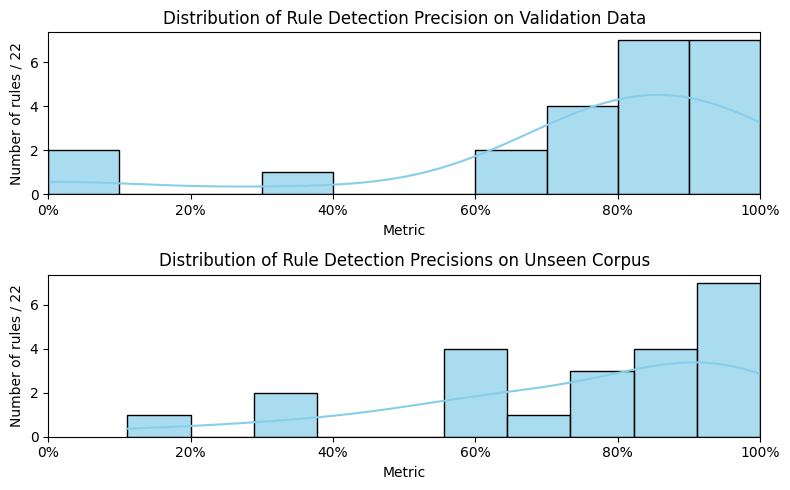

In [70]:
with open(metrics_path, 'r') as f:
    metrics = json.load(f)
correct_per_rule = coded_instances.groupby('#')['correct'].mean()
def plot_histogram(ax, data):
    sns.histplot(ax=ax, data=data, bins=10, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
    ax.set_ylabel(f"Number of rules / {len(correct_per_rule)}")
    ax.set_xlabel("Metric")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.set_xlim(0, 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
plot_histogram(axs[0], [m['precision'] for m in metrics.values()])
axs[0].set_title("Distribution of Rule Detection Precision on Validation Data")
plot_histogram(axs[1], list(correct_per_rule))
axs[1].set_title("Distribution of Rule Detection Precisions on Unseen Corpus")
plt.tight_layout()
plt.show()

In [77]:
del metrics['617']

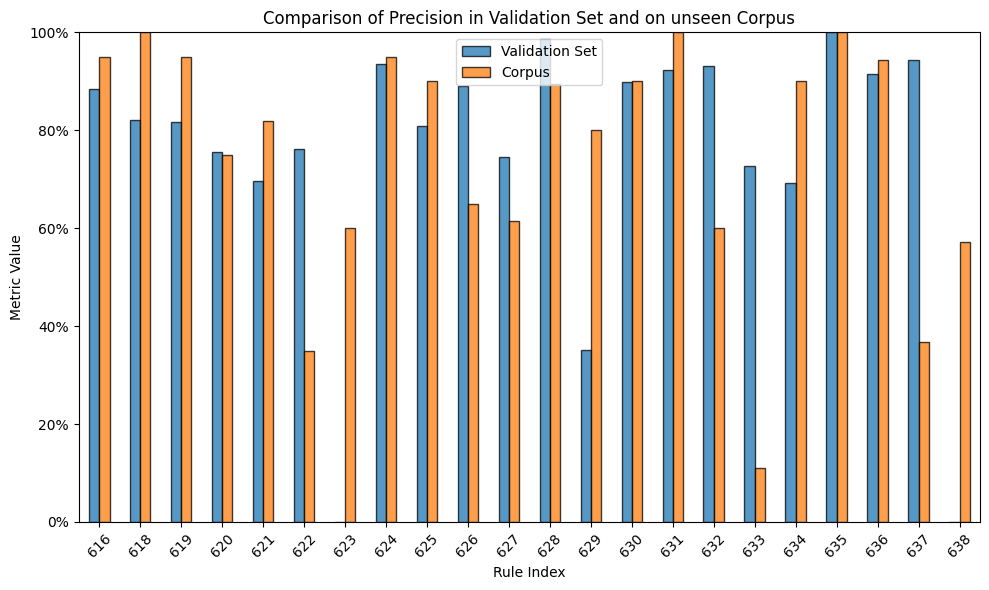

In [78]:
df = pd.DataFrame({'Validation Set': [m['precision'] for m in metrics.values()], 'Corpus': list(correct_per_rule)})
ax = df.plot(kind='bar', figsize=(10, 6), alpha=0.75, edgecolor='black')
ax.set_xlabel("Rule Index")
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Precision in Validation Set and on unseen Corpus")
ax.set_xticklabels(correct_per_rule.index, rotation=45)
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

plt.tight_layout()
plt.show()